<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/main/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Group Number: 21   |                  |                |
| ----------- | ----------------------- | -------------- |
| Student 1   | N.P.G.T. van Beuningen  | 1353624        |
| Student 2   | D.P.M. van der Hoorn    | 1873334        |
| Student 3   | L.R. Siecker            | 1344838        |

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# Change the following  line to the directory this notebook is (if using colab)
# In case you do not know the path, open the file navigator on the left in colab
# Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# Set the torch seed to prevent getting different performance when running again
torch.manual_seed(0)

In [6]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


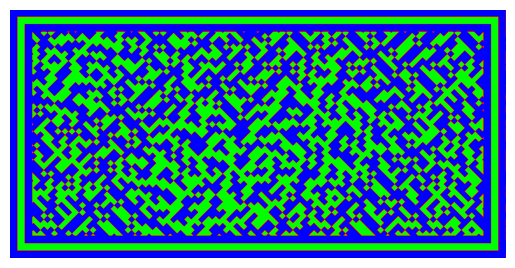

In [7]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [8]:
###     YOUR CODE FOR TASK 1    ###
class OriginPredictor(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            sc.Slice(4, False),

            sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            nn.Dropout2d(0.3),
            nn.ReLU(),

            sc.SymmetryPool(),

            nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(24, 3),
            nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)



In [9]:
from torch.utils.data import DataLoader

# dataloader training
dataloader_training = DataLoader(dataset=train_dataset,
                                 batch_size=32,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=val_dataset,
                                   batch_size=32,
                                   shuffle=True)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

class PlotTraining():
    def __init__(self):
      self.train_accuracy = []
      self.train_loss = []
      self.evaluation_accuracy = []
      self.evaluation_loss = []
      self.test_accuracy = []
      self.test_loss = []

    def add_train(self, accuracy, loss):
      self.train_accuracy.append(accuracy)
      self.train_loss.append(loss)

    def add_evaluation(self, accuracy, loss):
      self.evaluation_accuracy.append(accuracy)
      self.evaluation_loss.append(loss)

    def add_test(self, accuracy, loss):
      self.test_accuracy.append(accuracy)
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      if self.train_accuracy is not [None] * len(self.train_accuracy) \
          or self.evaluation_accuracy is not [None] * len(self.evaluation_accuracy) \
          or self.test_accuracy is not [None] * len(self.test_accuracy):
        ax1.set_ylabel('accuracy')
      ax2 = ax1.twinx()
      if self.train_loss is not [None] * len(self.train_loss) \
          or self.evaluation_loss is not [None] * len(self.evaluation_loss) \
          or self.test_loss is not [None] * len(self.test_loss):
        ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_accuracy:
        ax1.plot(list(range(len(self.train_accuracy))), self.train_accuracy, label = "Training Accuracy", color=color[0])
      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_accuracy:
        ax1.plot(list(range(len(self.evaluation_accuracy))), self.evaluation_accuracy, label = "Validation Accuracy", color=color[2])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Validation Loss", color=color[3])
      if self.test_accuracy:
        ax1.plot(list(range(len(self.test_accuracy))), self.test_accuracy, label = "Test Accuracy", color=color[4])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()
      

In [11]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):
        plotter = PlotTraining()

        for epoch in tqdm(range(self.epochs)):
                 
            train_acc, val_acc = [], []

            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                max_index_pred = torch.argmax(out, dim=1)
                max_index_test = torch.argmax(target, dim=1)

                pred_correct = torch.sum(max_index_pred == max_index_test)

                accuracy_value = 100*pred_correct.cpu().numpy()/len(out)
                train_acc.append(accuracy_value)
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss

                    max_index_pred = torch.argmax(out, dim=1)
                    max_index_test = torch.argmax(target, dim=1)

                    pred_correct = torch.sum(max_index_pred == max_index_test)

                    accuracy_value = 100*pred_correct.cpu().numpy()/len(out)
                    val_acc.append(accuracy_value)

                    loss_value = loss.item()
                    valid_losses.append(loss_value)

                  
                
            # print the results
            print(
                f' EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'TRAIN-ACC: {np.mean(train_acc):.2f}',end=' ')
            print(f'TRAIN-LOSS: {np.mean(train_losses):.4f}',end=' | ')
            print(f'VAL-ACC: {np.mean(val_acc):.2f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')
            plotter.add_train(np.mean(train_acc), np.mean(train_losses))
            plotter.add_evaluation(np.mean(val_acc), np.mean(valid_losses))
        plotter.plot()
   

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 5-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  5%|▌         | 1/20 [00:08<02:47,  8.80s/it]

 EPOCH: 01/20 TRAIN-ACC: 38.39 TRAIN-LOSS: 1.0843 | VAL-ACC: 51.74 VAL-LOSS: 1.0201


 10%|█         | 2/20 [00:10<01:22,  4.61s/it]

 EPOCH: 02/20 TRAIN-ACC: 68.81 TRAIN-LOSS: 0.8901 | VAL-ACC: 71.08 VAL-LOSS: 0.8548


 15%|█▌        | 3/20 [00:12<00:55,  3.26s/it]

 EPOCH: 03/20 TRAIN-ACC: 80.94 TRAIN-LOSS: 0.7597 | VAL-ACC: 65.53 VAL-LOSS: 0.8796


 20%|██        | 4/20 [00:13<00:42,  2.66s/it]

 EPOCH: 04/20 TRAIN-ACC: 85.70 TRAIN-LOSS: 0.7097 | VAL-ACC: 86.36 VAL-LOSS: 0.7107


 25%|██▌       | 5/20 [00:15<00:35,  2.38s/it]

 EPOCH: 05/20 TRAIN-ACC: 89.49 TRAIN-LOSS: 0.6714 | VAL-ACC: 83.04 VAL-LOSS: 0.7277


 30%|███       | 6/20 [00:17<00:30,  2.17s/it]

 EPOCH: 06/20 TRAIN-ACC: 92.29 TRAIN-LOSS: 0.6396 | VAL-ACC: 82.14 VAL-LOSS: 0.7274


 35%|███▌      | 7/20 [00:19<00:26,  2.01s/it]

 EPOCH: 07/20 TRAIN-ACC: 93.02 TRAIN-LOSS: 0.6276 | VAL-ACC: 93.45 VAL-LOSS: 0.6345


 40%|████      | 8/20 [00:20<00:22,  1.90s/it]

 EPOCH: 08/20 TRAIN-ACC: 94.11 TRAIN-LOSS: 0.6142 | VAL-ACC: 96.28 VAL-LOSS: 0.6043


 45%|████▌     | 9/20 [00:22<00:20,  1.83s/it]

 EPOCH: 09/20 TRAIN-ACC: 95.00 TRAIN-LOSS: 0.6061 | VAL-ACC: 94.49 VAL-LOSS: 0.6136


 50%|█████     | 10/20 [00:24<00:17,  1.79s/it]

 EPOCH: 10/20 TRAIN-ACC: 96.06 TRAIN-LOSS: 0.5961 | VAL-ACC: 92.46 VAL-LOSS: 0.6268


 55%|█████▌    | 11/20 [00:25<00:15,  1.75s/it]

 EPOCH: 11/20 TRAIN-ACC: 96.40 TRAIN-LOSS: 0.5923 | VAL-ACC: 94.25 VAL-LOSS: 0.6122


 60%|██████    | 12/20 [00:27<00:14,  1.76s/it]

 EPOCH: 12/20 TRAIN-ACC: 96.25 TRAIN-LOSS: 0.5936 | VAL-ACC: 92.91 VAL-LOSS: 0.6240


 65%|██████▌   | 13/20 [00:29<00:12,  1.80s/it]

 EPOCH: 13/20 TRAIN-ACC: 96.39 TRAIN-LOSS: 0.5904 | VAL-ACC: 93.01 VAL-LOSS: 0.6262


 70%|███████   | 14/20 [00:31<00:10,  1.79s/it]

 EPOCH: 14/20 TRAIN-ACC: 96.61 TRAIN-LOSS: 0.5895 | VAL-ACC: 96.92 VAL-LOSS: 0.5938


 75%|███████▌  | 15/20 [00:32<00:08,  1.75s/it]

 EPOCH: 15/20 TRAIN-ACC: 96.88 TRAIN-LOSS: 0.5852 | VAL-ACC: 96.92 VAL-LOSS: 0.5913


 80%|████████  | 16/20 [00:34<00:06,  1.73s/it]

 EPOCH: 16/20 TRAIN-ACC: 97.48 TRAIN-LOSS: 0.5791 | VAL-ACC: 95.73 VAL-LOSS: 0.5962


 85%|████████▌ | 17/20 [00:36<00:05,  1.71s/it]

 EPOCH: 17/20 TRAIN-ACC: 97.06 TRAIN-LOSS: 0.5828 | VAL-ACC: 96.78 VAL-LOSS: 0.5875


 90%|█████████ | 18/20 [00:38<00:03,  1.70s/it]

 EPOCH: 18/20 TRAIN-ACC: 97.37 TRAIN-LOSS: 0.5802 | VAL-ACC: 97.57 VAL-LOSS: 0.5820


 95%|█████████▌| 19/20 [00:39<00:01,  1.69s/it]

 EPOCH: 19/20 TRAIN-ACC: 97.54 TRAIN-LOSS: 0.5786 | VAL-ACC: 96.13 VAL-LOSS: 0.5943


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]

 EPOCH: 20/20 TRAIN-ACC: 97.29 TRAIN-LOSS: 0.5799 | VAL-ACC: 97.27 VAL-LOSS: 0.5836


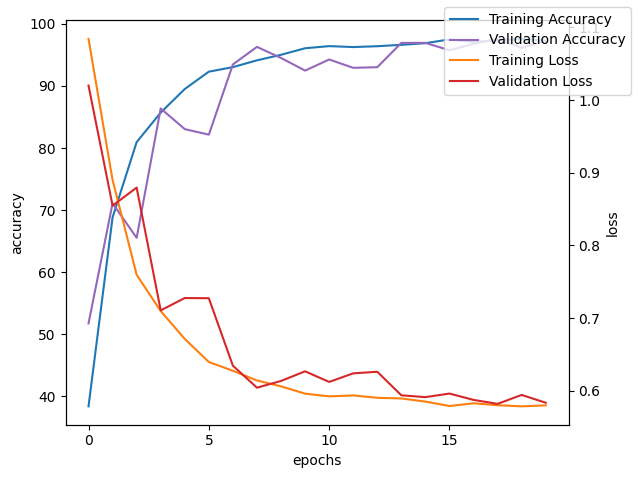

In [12]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')

originpred = OriginPredictor()

model = originpred.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  epochs=20)

trainer.run_trainer()

Carpet from Reinforciya is predicted as Reinforciya


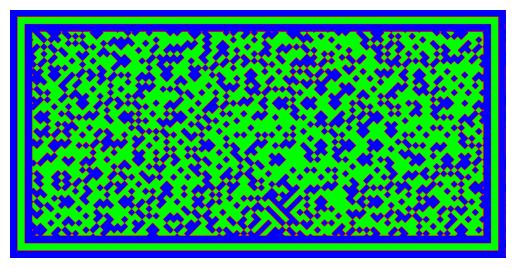

In [13]:
'''
(For the test dataset)
1. For each class a good classified carpet
2. For each class if possible a wrongly classified carpet
3. Accuracy of the model
'''

idx = np.random.randint(0,X_test.size(0))

model.eval()

with torch.no_grad():
    out = model(X_test[idx,None].to(device))  # send through model/network


max_index = torch.argmax(out, dim=1)

test_label = oh_to_label(y_test[idx,None])[0]

cls_dict = {0: 'Convolushahr', 1:'Transformabad', 2:'Reinforciya'}
pred_label = cls_dict[max_index.cpu().numpy()[0]]
show_carpet(X_test, idx)
print('Carpet from', test_label, 'is predicted as', pred_label)

In [14]:
model.eval()
with torch.no_grad():
    out = model(X_val.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model(X_test.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

Accuracy of the model on the validation set: 97.3%
Accuracy of the model on the test set: 97.4%


## Task 1: Question 5d

  5%|▌         | 1/20 [00:00<00:16,  1.19it/s]

 EPOCH: 01/20 TRAIN-ACC: 34.33 TRAIN-LOSS: 1.1031 | VAL-ACC: 37.95 VAL-LOSS: 1.0880


 10%|█         | 2/20 [00:01<00:14,  1.25it/s]

 EPOCH: 02/20 TRAIN-ACC: 80.12 TRAIN-LOSS: 0.7719 | VAL-ACC: 97.92 VAL-LOSS: 0.5899


 15%|█▌        | 3/20 [00:02<00:13,  1.27it/s]

 EPOCH: 03/20 TRAIN-ACC: 98.76 TRAIN-LOSS: 0.5765 | VAL-ACC: 99.21 VAL-LOSS: 0.5669


 20%|██        | 4/20 [00:03<00:12,  1.26it/s]

 EPOCH: 04/20 TRAIN-ACC: 99.60 TRAIN-LOSS: 0.5628 | VAL-ACC: 99.06 VAL-LOSS: 0.5657


 25%|██▌       | 5/20 [00:03<00:11,  1.29it/s]

 EPOCH: 05/20 TRAIN-ACC: 99.77 TRAIN-LOSS: 0.5575 | VAL-ACC: 99.21 VAL-LOSS: 0.5633


 30%|███       | 6/20 [00:04<00:10,  1.28it/s]

 EPOCH: 06/20 TRAIN-ACC: 99.64 TRAIN-LOSS: 0.5585 | VAL-ACC: 99.60 VAL-LOSS: 0.5589


 35%|███▌      | 7/20 [00:05<00:10,  1.28it/s]

 EPOCH: 07/20 TRAIN-ACC: 99.63 TRAIN-LOSS: 0.5576 | VAL-ACC: 98.86 VAL-LOSS: 0.5651


 40%|████      | 8/20 [00:06<00:09,  1.29it/s]

 EPOCH: 08/20 TRAIN-ACC: 99.57 TRAIN-LOSS: 0.5589 | VAL-ACC: 99.16 VAL-LOSS: 0.5619


 45%|████▌     | 9/20 [00:07<00:08,  1.30it/s]

 EPOCH: 09/20 TRAIN-ACC: 99.91 TRAIN-LOSS: 0.5543 | VAL-ACC: 99.26 VAL-LOSS: 0.5613


 50%|█████     | 10/20 [00:07<00:07,  1.30it/s]

 EPOCH: 10/20 TRAIN-ACC: 99.92 TRAIN-LOSS: 0.5531 | VAL-ACC: 99.80 VAL-LOSS: 0.5572


 55%|█████▌    | 11/20 [00:08<00:06,  1.30it/s]

 EPOCH: 11/20 TRAIN-ACC: 99.91 TRAIN-LOSS: 0.5535 | VAL-ACC: 99.45 VAL-LOSS: 0.5590


 60%|██████    | 12/20 [00:09<00:06,  1.30it/s]

 EPOCH: 12/20 TRAIN-ACC: 99.83 TRAIN-LOSS: 0.5545 | VAL-ACC: 98.02 VAL-LOSS: 0.5727


 65%|██████▌   | 13/20 [00:10<00:05,  1.30it/s]

 EPOCH: 13/20 TRAIN-ACC: 99.45 TRAIN-LOSS: 0.5580 | VAL-ACC: 99.01 VAL-LOSS: 0.5637


 70%|███████   | 14/20 [00:11<00:04,  1.21it/s]

 EPOCH: 14/20 TRAIN-ACC: 99.61 TRAIN-LOSS: 0.5561 | VAL-ACC: 98.91 VAL-LOSS: 0.5638


 75%|███████▌  | 15/20 [00:12<00:04,  1.15it/s]

 EPOCH: 15/20 TRAIN-ACC: 99.69 TRAIN-LOSS: 0.5554 | VAL-ACC: 99.11 VAL-LOSS: 0.5614


 80%|████████  | 16/20 [00:13<00:03,  1.10it/s]

 EPOCH: 16/20 TRAIN-ACC: 99.69 TRAIN-LOSS: 0.5551 | VAL-ACC: 98.31 VAL-LOSS: 0.5688


 85%|████████▌ | 17/20 [00:13<00:02,  1.10it/s]

 EPOCH: 17/20 TRAIN-ACC: 99.85 TRAIN-LOSS: 0.5537 | VAL-ACC: 98.26 VAL-LOSS: 0.5686


 90%|█████████ | 18/20 [00:14<00:01,  1.16it/s]

 EPOCH: 18/20 TRAIN-ACC: 99.84 TRAIN-LOSS: 0.5538 | VAL-ACC: 98.76 VAL-LOSS: 0.5632


 95%|█████████▌| 19/20 [00:15<00:00,  1.20it/s]

 EPOCH: 19/20 TRAIN-ACC: 99.67 TRAIN-LOSS: 0.5552 | VAL-ACC: 98.86 VAL-LOSS: 0.5645


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

 EPOCH: 20/20 TRAIN-ACC: 99.80 TRAIN-LOSS: 0.5540 | VAL-ACC: 99.01 VAL-LOSS: 0.5626


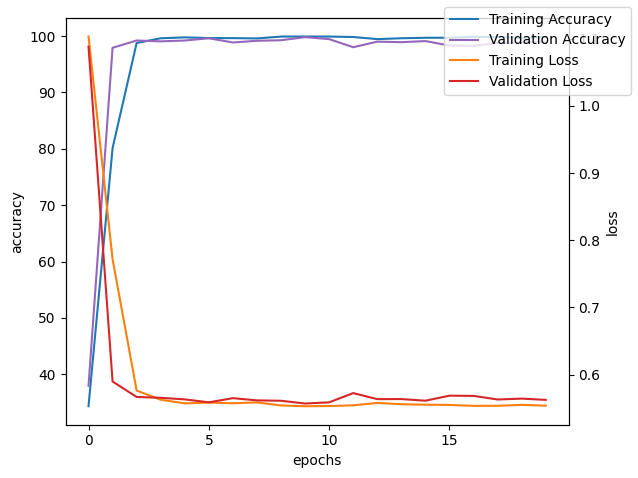

Accuracy of the model on the validation set: 99.0%
Accuracy of the model on the test set: 99.4%


  5%|▌         | 1/20 [00:01<00:30,  1.59s/it]

 EPOCH: 01/20 TRAIN-ACC: 33.69 TRAIN-LOSS: 1.2133 | VAL-ACC: 31.99 VAL-LOSS: 1.2315


 10%|█         | 2/20 [00:03<00:27,  1.55s/it]

 EPOCH: 02/20 TRAIN-ACC: 33.89 TRAIN-LOSS: 1.2120 | VAL-ACC: 31.85 VAL-LOSS: 1.2330


 15%|█▌        | 3/20 [00:04<00:26,  1.54s/it]

 EPOCH: 03/20 TRAIN-ACC: 33.58 TRAIN-LOSS: 1.2139 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 20%|██        | 4/20 [00:06<00:24,  1.54s/it]

 EPOCH: 04/20 TRAIN-ACC: 33.69 TRAIN-LOSS: 1.2139 | VAL-ACC: 31.80 VAL-LOSS: 1.2335


 25%|██▌       | 5/20 [00:07<00:23,  1.55s/it]

 EPOCH: 05/20 TRAIN-ACC: 33.75 TRAIN-LOSS: 1.2136 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 30%|███       | 6/20 [00:09<00:22,  1.58s/it]

 EPOCH: 06/20 TRAIN-ACC: 33.77 TRAIN-LOSS: 1.2132 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 35%|███▌      | 7/20 [00:10<00:20,  1.58s/it]

 EPOCH: 07/20 TRAIN-ACC: 33.76 TRAIN-LOSS: 1.2132 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 40%|████      | 8/20 [00:12<00:18,  1.57s/it]

 EPOCH: 08/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.2134 | VAL-ACC: 32.04 VAL-LOSS: 1.2310


 45%|████▌     | 9/20 [00:14<00:17,  1.56s/it]

 EPOCH: 09/20 TRAIN-ACC: 33.67 TRAIN-LOSS: 1.2137 | VAL-ACC: 31.99 VAL-LOSS: 1.2315


 50%|█████     | 10/20 [00:15<00:15,  1.55s/it]

 EPOCH: 10/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.2138 | VAL-ACC: 31.85 VAL-LOSS: 1.2330


 55%|█████▌    | 11/20 [00:17<00:13,  1.54s/it]

 EPOCH: 11/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.2129 | VAL-ACC: 31.80 VAL-LOSS: 1.2335


 60%|██████    | 12/20 [00:18<00:12,  1.55s/it]

 EPOCH: 12/20 TRAIN-ACC: 33.64 TRAIN-LOSS: 1.2136 | VAL-ACC: 31.75 VAL-LOSS: 1.2340


 65%|██████▌   | 13/20 [00:20<00:10,  1.54s/it]

 EPOCH: 13/20 TRAIN-ACC: 33.66 TRAIN-LOSS: 1.2131 | VAL-ACC: 31.75 VAL-LOSS: 1.2340


 70%|███████   | 14/20 [00:21<00:09,  1.58s/it]

 EPOCH: 14/20 TRAIN-ACC: 33.71 TRAIN-LOSS: 1.2134 | VAL-ACC: 31.94 VAL-LOSS: 1.2320


 75%|███████▌  | 15/20 [00:23<00:07,  1.60s/it]

 EPOCH: 15/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.2140 | VAL-ACC: 31.70 VAL-LOSS: 1.2345


 80%|████████  | 16/20 [00:25<00:06,  1.58s/it]

 EPOCH: 16/20 TRAIN-ACC: 33.95 TRAIN-LOSS: 1.2119 | VAL-ACC: 31.99 VAL-LOSS: 1.2315


 85%|████████▌ | 17/20 [00:26<00:04,  1.57s/it]

 EPOCH: 17/20 TRAIN-ACC: 33.63 TRAIN-LOSS: 1.2139 | VAL-ACC: 31.75 VAL-LOSS: 1.2340


 90%|█████████ | 18/20 [00:28<00:03,  1.57s/it]

 EPOCH: 18/20 TRAIN-ACC: 33.58 TRAIN-LOSS: 1.2144 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 95%|█████████▌| 19/20 [00:29<00:01,  1.56s/it]

 EPOCH: 19/20 TRAIN-ACC: 33.67 TRAIN-LOSS: 1.2133 | VAL-ACC: 31.85 VAL-LOSS: 1.2330


100%|██████████| 20/20 [00:31<00:00,  1.56s/it]

 EPOCH: 20/20 TRAIN-ACC: 33.73 TRAIN-LOSS: 1.2133 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


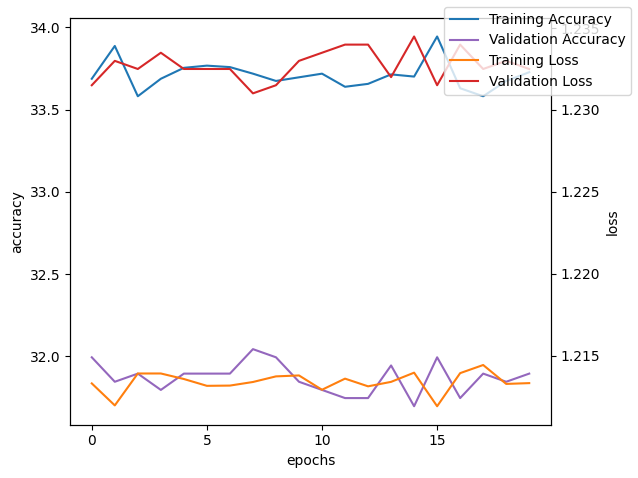

Accuracy of the model on the validation set: 31.85%
Accuracy of the model on the test set: 32.6%


  5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

 EPOCH: 01/20 TRAIN-ACC: 33.61 TRAIN-LOSS: 1.2137 | VAL-ACC: 31.80 VAL-LOSS: 1.2335


 10%|█         | 2/20 [00:01<00:10,  1.75it/s]

 EPOCH: 02/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.2143 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 15%|█▌        | 3/20 [00:01<00:09,  1.77it/s]

 EPOCH: 03/20 TRAIN-ACC: 33.79 TRAIN-LOSS: 1.2136 | VAL-ACC: 31.75 VAL-LOSS: 1.2340


 20%|██        | 4/20 [00:02<00:09,  1.62it/s]

 EPOCH: 04/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.2143 | VAL-ACC: 31.75 VAL-LOSS: 1.2340


 25%|██▌       | 5/20 [00:03<00:09,  1.54it/s]

 EPOCH: 05/20 TRAIN-ACC: 33.67 TRAIN-LOSS: 1.2147 | VAL-ACC: 31.80 VAL-LOSS: 1.2335


 30%|███       | 6/20 [00:03<00:09,  1.50it/s]

 EPOCH: 06/20 TRAIN-ACC: 33.76 TRAIN-LOSS: 1.2138 | VAL-ACC: 31.85 VAL-LOSS: 1.2330


 35%|███▌      | 7/20 [00:04<00:08,  1.48it/s]

 EPOCH: 07/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.2143 | VAL-ACC: 31.94 VAL-LOSS: 1.2320


 40%|████      | 8/20 [00:05<00:08,  1.48it/s]

 EPOCH: 08/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.2143 | VAL-ACC: 31.75 VAL-LOSS: 1.2340


 45%|████▌     | 9/20 [00:05<00:07,  1.57it/s]

 EPOCH: 09/20 TRAIN-ACC: 33.67 TRAIN-LOSS: 1.2147 | VAL-ACC: 31.75 VAL-LOSS: 1.2340


 50%|█████     | 10/20 [00:06<00:06,  1.62it/s]

 EPOCH: 10/20 TRAIN-ACC: 33.72 TRAIN-LOSS: 1.2143 | VAL-ACC: 31.85 VAL-LOSS: 1.2330


 55%|█████▌    | 11/20 [00:06<00:05,  1.67it/s]

 EPOCH: 11/20 TRAIN-ACC: 33.79 TRAIN-LOSS: 1.2136 | VAL-ACC: 31.94 VAL-LOSS: 1.2320


 60%|██████    | 12/20 [00:07<00:04,  1.70it/s]

 EPOCH: 12/20 TRAIN-ACC: 33.65 TRAIN-LOSS: 1.2149 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 65%|██████▌   | 13/20 [00:07<00:04,  1.72it/s]

 EPOCH: 13/20 TRAIN-ACC: 33.65 TRAIN-LOSS: 1.2149 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 70%|███████   | 14/20 [00:08<00:03,  1.75it/s]

 EPOCH: 14/20 TRAIN-ACC: 33.74 TRAIN-LOSS: 1.2140 | VAL-ACC: 31.80 VAL-LOSS: 1.2335


 75%|███████▌  | 15/20 [00:09<00:02,  1.75it/s]

 EPOCH: 15/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.2145 | VAL-ACC: 31.94 VAL-LOSS: 1.2320


 80%|████████  | 16/20 [00:09<00:02,  1.76it/s]

 EPOCH: 16/20 TRAIN-ACC: 33.70 TRAIN-LOSS: 1.2145 | VAL-ACC: 32.04 VAL-LOSS: 1.2310


 85%|████████▌ | 17/20 [00:10<00:01,  1.77it/s]

 EPOCH: 17/20 TRAIN-ACC: 33.81 TRAIN-LOSS: 1.2134 | VAL-ACC: 31.89 VAL-LOSS: 1.2325


 90%|█████████ | 18/20 [00:10<00:01,  1.78it/s]

 EPOCH: 18/20 TRAIN-ACC: 33.76 TRAIN-LOSS: 1.2138 | VAL-ACC: 31.80 VAL-LOSS: 1.2335


 95%|█████████▌| 19/20 [00:11<00:00,  1.79it/s]

 EPOCH: 19/20 TRAIN-ACC: 33.65 TRAIN-LOSS: 1.2149 | VAL-ACC: 31.85 VAL-LOSS: 1.2330


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]

 EPOCH: 20/20 TRAIN-ACC: 33.74 TRAIN-LOSS: 1.2140 | VAL-ACC: 31.80 VAL-LOSS: 1.2335


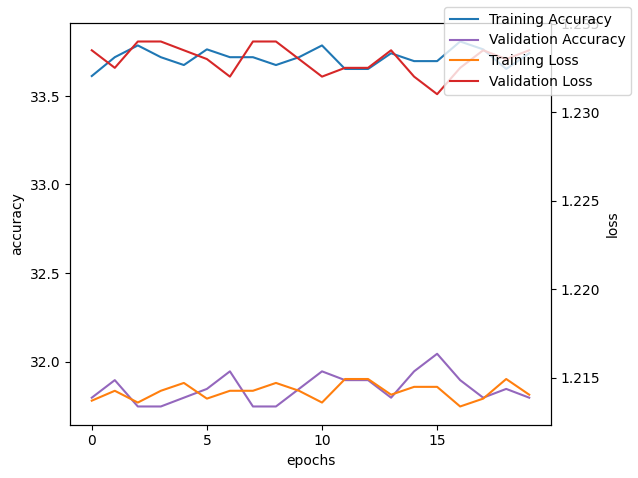

Accuracy of the model on the validation set: 31.85%
Accuracy of the model on the test set: 32.6%


In [15]:
# Make class for performing training procedure given predictor model
class AblationTester():
  def __init__(self):
    pass

  def run_test(self, predictor):
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else:
        device = torch.device('cpu')

    model = predictor.to(device)

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    trainer = Trainer(model=model,
                      device=device,
                      criterion=criterion,
                      optimizer=optimizer,
                      training_DataLoader=dataloader_training,
                      validation_DataLoader=dataloader_validation,
                      epochs=20)

    trainer.run_trainer()
    return model
ablation_tester = AblationTester()

"""
Test 1: Remove the symmetry-related components by commenting out the slice layer, the symmetryconv layer, and the symmetry pool layer
"""
class OriginPredictor_test1(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor_test1, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            # sc.Slice(4, False),

            # sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            # nn.Dropout2d(0.3),
            # nn.ReLU(),

            # sc.SymmetryPool(),

            nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(96, 3),
            nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)

model_test1 = ablation_tester.run_test(OriginPredictor_test1())

model_test1.eval()
with torch.no_grad():
    out = model_test1(X_val.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model_test1(X_test.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

"""
Test 2: Remove later convolutional layers that recognize super cells and global patterns
"""
class OriginPredictor_test2(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor_test2, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            sc.Slice(4, False),

            sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            nn.Dropout2d(0.3),
            nn.ReLU(),

            sc.SymmetryPool(),

            # nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),

            # nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(8800, 3),
            nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)

model_test2 = ablation_tester.run_test(OriginPredictor_test2())

model_test2.eval()
with torch.no_grad():
    out = model_test2(X_val.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model_test2(X_test.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

"""
Test 3: Remove everything but input layer and last linear layer
"""
class OriginPredictor_test3(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictor_test3, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 40, kernel_size=4, stride=4, padding=1),
            nn.ReLU(),

            # sc.Slice(4, False),

            # sc.SymmetryConv2d(40, 40, 5, rotation=4, reflection=False),
            # nn.Dropout2d(0.3),
            # nn.ReLU(),

            # sc.SymmetryPool(),

            # nn.Conv2d(40, 24, kernel_size=3, stride=3, padding=2),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),

            # nn.Conv2d(24, 24, kernel_size=(8,5), stride=1),
            # nn.BatchNorm2d(24),
            # nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(14400, 3),
            nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)

model_test3 = ablation_tester.run_test(OriginPredictor_test3())

model_test3.eval()
with torch.no_grad():
    out = model_test3(X_val.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_val.to(device), dim=1)
pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the validation set: {round(100*pred_correct.cpu().numpy()/len(y_val),2)}%')

with torch.no_grad():
    out = model_test3(X_test.to(device))  # send through model/network

max_index_pred = torch.argmax(out, dim=1)
max_index_test = torch.argmax(y_test.to(device), dim=1)

pred_correct = torch.sum(max_index_pred == max_index_test)

print(f'Accuracy of the model on the test set: {round(100*pred_correct.cpu().numpy()/len(y_test),2)}%')

In [16]:
del X
del y
torch.cuda.empty_cache()

# Task 2: Carpet Matching 

In [17]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

In [18]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [19]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = mined_model.get_embedding(q).cpu().numpy()
            emb_t = mined_model.get_embedding(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [20]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###

In [21]:
""" 
Training data: 1500 carpets form 200 different settlements --> use to train a suitable solution
Test data: 300 queries, carpets in the test dataset come from a different region of the country and their origin does not match any of the 200 settlements given in the training data

One-shot siamese network: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
Notice that this network is not learning to classify an image directly to any of the output classes. 
Rather, it is learning a similarity function, which takes two images as input and expresses how similar they are.

https://towardsdatascience.com/neural-networks-intuitions-9-distance-metric-learning-dae7c3a0ebdf --> blijkbaar doet Siamese network dus alles met 2 images, terwijl triplet loss dus met 3 iamges werkt, maar
volgens dit artikel kun je een Siamese Neural Network ook met een triplet loss function trainen https://medium.com/@enoshshr/triplet-loss-and-siamese-neural-networks-5d363fdeba9b
"""

' \nTraining data: 1500 carpets form 200 different settlements --> use to train a suitable solution\nTest data: 300 queries, carpets in the test dataset come from a different region of the country and their origin does not match any of the 200 settlements given in the training data\n\nOne-shot siamese network: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d\nNotice that this network is not learning to classify an image directly to any of the output classes. \nRather, it is learning a similarity function, which takes two images as input and expresses how similar they are.\n\nhttps://towardsdatascience.com/neural-networks-intuitions-9-distance-metric-learning-dae7c3a0ebdf --> blijkbaar doet Siamese network dus alles met 2 images, terwijl triplet loss dus met 3 iamges werkt, maar\nvolgens dit artikel kun je een Siamese Neural Network ook met een triplet loss function trainen https://medium.com/@enoshshr/triplet-loss-and-siamese-neural-networ

In [22]:
class OriginPredictorEmbedding(nn.Module):
    def __init__(self) -> None:
        super(OriginPredictorEmbedding, self).__init__()

        self.model = nn.Sequential(
            
            nn.Conv2d(1, 24, kernel_size=4, stride=4, padding=1),
            nn.Dropout(0.2),
            nn.ReLU(),

            sc.Slice(4, False),

            sc.SymmetryConv2d(24, 96, 5, rotation=4, reflection=False),
            nn.Dropout(0.5),
            nn.ReLU(),

            sc.SymmetryPool(),

            nn.Conv2d(96, 200, kernel_size=3, stride=3, padding=2),
            nn.BatchNorm2d(200),
            nn.Dropout2d(0.5),
            nn.ReLU(),

            # nn.Conv2d(200, 200, kernel_size=(8,5), stride=1),
            # nn.BatchNorm2d(200),
            # nn.Dropout2d(0.5),
            # nn.ReLU(),
            
            nn.Flatten(),

            nn.Linear(8000, 200),
            # nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)

    def get_embedding(self, x):
        return self.forward(x)

In [23]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [24]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        negative_idx= triplets[:, 2]  
            
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)
        # print(f"Distance: {ap_distances - an_distances}")

        return losses.mean()

In [25]:
X = torch.tensor(X)
y = torch.tensor(y)


train_dataset = TensorDataset(X.to(torch.float32), y.to(torch.float32)) #zonder die converts kreeg ik error maar misschien moeten we iets van .clone() gebruiken? Even uitzoeken

# batch sampler for training
train_batch_sampler = BalancedBatchSampler(y.tolist(), n_classes=len(np.unique(y)), n_samples=10)

# dataloader training
dataloader_training = DataLoader(dataset=train_dataset,
                                 batch_sampler=train_batch_sampler)


In [26]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [27]:
from itertools import combinations
class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()
  
        self.margin = margin
  
   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):
        
        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None

    def get_triplets(self, embeddings, labels):
        
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                
                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positives[0], anchor_positives[1], negative_indicess[0]])

        triplets = np.array(triplets)
        
        return torch.LongTensor(triplets)
        

In [38]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):

        plotter = PlotTraining()
        for epoch in tqdm(range(self.epochs)):

            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters

                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end='\n')
            plotter.add_train(None, np.mean(train_losses))
        plotter.plot()

  5%|▌         | 1/20 [00:12<03:52, 12.25s/it]

EPOCH: 01/20 LOSS: 127.3525


 10%|█         | 2/20 [00:24<03:45, 12.54s/it]

EPOCH: 02/20 LOSS: 147.3340


 15%|█▌        | 3/20 [00:36<03:25, 12.12s/it]

EPOCH: 03/20 LOSS: 87.9026


 20%|██        | 4/20 [00:48<03:11, 11.95s/it]

EPOCH: 04/20 LOSS: 45.6959


 25%|██▌       | 5/20 [01:00<03:00, 12.01s/it]

EPOCH: 05/20 LOSS: 22.3512


 30%|███       | 6/20 [01:12<02:48, 12.04s/it]

EPOCH: 06/20 LOSS: 10.4207


 35%|███▌      | 7/20 [01:25<02:40, 12.35s/it]

EPOCH: 07/20 LOSS: 5.0103


 40%|████      | 8/20 [01:37<02:27, 12.28s/it]

EPOCH: 08/20 LOSS: 2.5986


 45%|████▌     | 9/20 [01:49<02:14, 12.24s/it]

EPOCH: 09/20 LOSS: 1.5359


 50%|█████     | 10/20 [02:01<02:02, 12.22s/it]

EPOCH: 10/20 LOSS: 1.0526


 55%|█████▌    | 11/20 [02:14<01:50, 12.29s/it]

EPOCH: 11/20 LOSS: 0.8076


 60%|██████    | 12/20 [02:26<01:37, 12.17s/it]

EPOCH: 12/20 LOSS: 0.6871


 65%|██████▌   | 13/20 [02:37<01:23, 11.97s/it]

EPOCH: 13/20 LOSS: 0.6222


 70%|███████   | 14/20 [02:49<01:12, 12.02s/it]

EPOCH: 14/20 LOSS: 0.5892


 75%|███████▌  | 15/20 [03:02<01:00, 12.03s/it]

EPOCH: 15/20 LOSS: 0.5688


 80%|████████  | 16/20 [03:14<00:48, 12.02s/it]

EPOCH: 16/20 LOSS: 0.5545


 85%|████████▌ | 17/20 [03:26<00:36, 12.08s/it]

EPOCH: 17/20 LOSS: 0.5502


 90%|█████████ | 18/20 [03:39<00:24, 12.49s/it]

EPOCH: 18/20 LOSS: 0.5412


 95%|█████████▌| 19/20 [03:51<00:12, 12.42s/it]

EPOCH: 19/20 LOSS: 0.5408


100%|██████████| 20/20 [04:04<00:00, 12.21s/it]

EPOCH: 20/20 LOSS: 0.5372


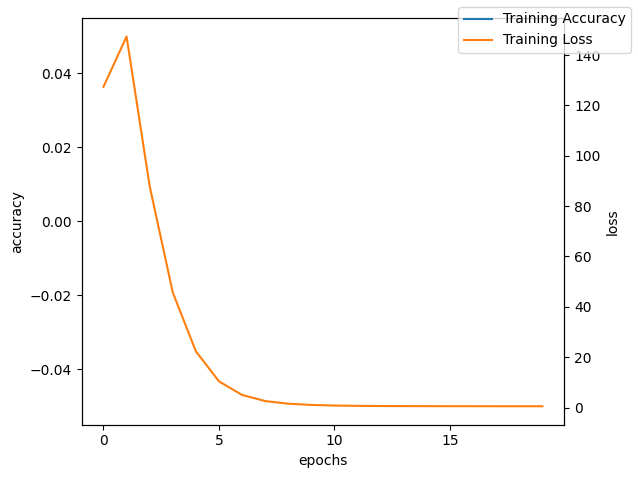

In [42]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
mined_embedding_net = OriginPredictorEmbedding()
mined_model = mined_embedding_net.to(device)


# margin value
margin=0.5

# criterion
criterion = TripletLoss(margin, Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.Adam(mined_model.parameters(), lr=0.01, weight_decay=0.0005)

# trainer
trainer = Trainer(model=mined_model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  epochs=20)

# start training
trainer.run_trainer()

In [43]:
mined_model.eval()
top = 1
accuracy = query_performance(torch.from_numpy(queries), torch.from_numpy(targets), torch.from_numpy(gt), top=top)
print(f'Accuracy of the model on the queries for top = {top}: {round(accuracy,2)}%')

top = 2
accuracy = query_performance(torch.from_numpy(queries), torch.from_numpy(targets), torch.from_numpy(gt), top=top)
print(f'Accuracy of the model on the queries for top = {top}: {round(accuracy,2)}%')

top = 3
accuracy = query_performance(torch.from_numpy(queries), torch.from_numpy(targets), torch.from_numpy(gt), top=top)
print(f'Accuracy of the model on the queries for top = {top}: {round(accuracy,2)}%')

Accuracy of the model on the queries for top = 1: 94.0%
Accuracy of the model on the queries for top = 2: 99.0%
Accuracy of the model on the queries for top = 3: 99.67%


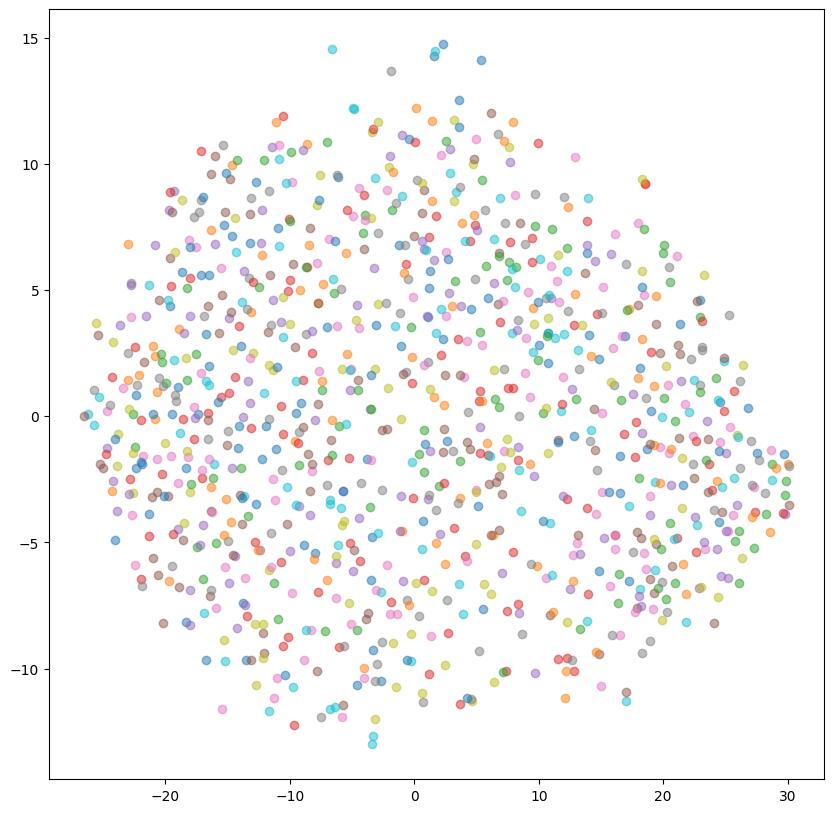

In [32]:
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, targets, xlim=None, ylim=None):
    
    
    # The first 3000 embeddings and targets
    embeddings= embeddings[:3000]
    targets= targets[:3000]

    # Using Tsne to for dimension reduction 
    tsne = TSNE(n_components=2, perplexity=50)
    embeddings = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10,10))
    for i in classes:
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    # plt.legend(classes)

vis_data = X[:1000]
classes = np.unique(y[:1000])
train_embeddings = mined_model.get_embedding(vis_data.to(torch.float32).to(device))
plot_tsne_embeddings(train_embeddings.detach().cpu(), y[:1000].tolist())

In [44]:
torch.save(mined_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Deep Learning/A1P2_model.pt')